In [1]:
import mdtraj as md
import pyemma as pm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Optional, Union, Tuple
from pathlib import Path
import pickle
import seaborn as sns

from matplotlib import colors

from msmtools.estimation import transition_matrix as _transition_matrix
from msmtools.analysis import timescales as _timescales

import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Dihedral, Ramachandran

/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def featurizer(hp_dict: Dict, traj_paths: List[str], top_path: str) -> List[np.ndarray]:
    if hp_dict['feature__value'] == 'dihedrals':
        assert hp_dict['dihedrals__which'] == 'all'
        def f(traj: md.Trajectory, **kwargs) -> np.ndarray:
            _, phi = md.compute_phi(traj)
            _, psi = md.compute_psi(traj)
            _, chi1 = md.compute_chi1(traj)
            _, chi2 = md.compute_chi2(traj)
            _, chi3 = md.compute_chi3(traj)
            _, chi4 = md.compute_chi4(traj)
            _, chi5 = md.compute_chi5(traj)
            ftraj = np.concatenate([phi, psi, chi1, chi2, chi3, chi4, chi5], axis=1)
            ftraj = np.concatenate([np.cos(ftraj), np.sin(ftraj)], axis=1)
            return ftraj

    elif hp_dict['feature__value'] == 'distances':
        def f(traj: md.Trajectory, **kwargs):
            scheme = kwargs['distances__scheme']
            transform = kwargs['distances__transform']
            centre = kwargs['distances__centre']
            steepness = kwargs['distances__steepness']
            ftraj, _ = md.compute_contacts(traj, scheme=scheme)
            if transform=='logistic':
                ftraj = 1.0/(1+np.exp(-steepness*(ftraj - centre)))
            return ftraj
    else:
        raise ValueError
    ftrajs = []
    for traj_path in traj_paths:
        traj = md.load(traj_path, top=top_path)
        ftrajs.append(f(traj, **hp_dict))
    return ftrajs


def tica(hp_dict: Dict[str, Union[float, int, str]], ftrajs: List[np.ndarray]) -> List[np.ndarray]:
    lag = hp_dict['tica__lag']
    stride = hp_dict['tica__stride']
    dim = hp_dict['tica__dim']
    tica = pm.coordinates.tica(ftrajs, lag=lag, dim=dim, kinetic_map=True)
    ttrajs = tica.get_output()
    return ttrajs, tica

def kmeans(hp_dict: Dict, ttrajs: List[np.ndarray], seed: int) -> List[np.ndarray]:
    k = hp_dict['cluster__k']
    max_iter = hp_dict['cluster__max_iter']
    stride = hp_dict['cluster__stride']
    kmeans = pm.coordinates.cluster_kmeans(ttrajs, k=k, max_iter=max_iter, stride=stride, fixed_seed=seed, n_jobs=1)
    dtrajs = kmeans.dtrajs
    return dtrajs, kmeans


def its(dtrajs: List[np.ndarray], lags: List[int], nits: int) -> np.ndarray:
    its_obj = pm.msm.timescales_msm(dtrajs=dtrajs, lags=lags, nits=nits)
    return its_obj.timescales


def score(dtrajs: List[np.ndarray], lags: List[int], nits: int) -> np.ndarray:
    all_vs = []
    for lag in lags: 
        m = pm.msm.estimate_markov_model(dtrajs, lag=lag)
        vs = np.array([m.score(dtrajs, score_k=k) for k in range(2, nits+2)])
        vs = vs.reshape(1, -1)
        all_vs.append(vs)
    all_vs = np.concatenate(all_vs, axis=0)
    return all_vs
        


def bootstrap(ftrajs: List[np.ndarray], rng: np.random.Generator) -> List[np.ndarray]:
    probs = np.array([x.shape[0] for x in ftrajs])
    probs = probs/np.sum(probs)
    ix = np.arange(len(ftrajs))
    new_ix = rng.choice(ix,size=len(ftrajs), p=probs, replace=True)
    return [ftrajs[i] for i in new_ix], new_ix



def summarise(df):
    df_summary = df.groupby(['hp_ix', 'lag', 'process']).agg(median=(0, lambda x: np.quantile(x, 0.5)),
                                                                   lb=(0, lambda x: np.quantile(x, 0.025)),
                                                                   ub=(0, lambda x: np.quantile(x, 0.975)), 
                                                                   count =(0, lambda x: x.shape[0]-x.isna().sum()))
    return df_summary


def samples_to_summary(samples: np.ndarray, lags: List[int],  hp_ix: int)-> pd.DataFrame: 
    """
    samples=np.ndarray[lagtime, process, bs_sample]
    """
    df = pd.concat({(hp_ix, lags[i], j+2): pd.DataFrame(samples[i, j, :]) for i in range(samples.shape[0]) for j in range(samples.shape[1])})
    df.index.rename(('hp_ix', 'lag', 'process', 'bs_ix'), inplace=True)
    df_summary = summarise(df)
    return df_summary

In [3]:
protein = 'CLN'
seed = 54267
rng = np.random.default_rng(seed)
lags = list(range(1, 102, 10))
n_bootstraps = 1
nits= 25
hp_ix = 74
lag = 31

hps = pd.read_hdf('../../../hpsample_stride1.h5')
top_path = '../../../chignolin/protein.pdb'
traj_paths = list(Path(r'../../../chignolin').rglob(f'CLN025-0-protein-*.xtc'))
traj_paths = [str(x) for x in traj_paths]
traj_paths.sort()
assert traj_paths

# source_ts = pd.DataFrame(pd.read_hdf(f'../analysis/{protein}/summary_batch1.h5', key='timescales'))
# source_vs = pd.DataFrame(pd.read_hdf(f'../analysis/{protein}/summary_batch1.h5', key='vamps'))

In [4]:
print(hps.loc[hp_ix, :].to_dict())

ftrajs_all = featurizer(hps.loc[hp_ix, :].to_dict(), traj_paths, top_path)
# Bootstrap results
ts_samples = []
vs_samples = []
for i in range(n_bootstraps):
#     if n_bootstraps>1: 
#         print(i, end=', ')
#     ftrajs, ix = bootstrap(ftrajs_all, rng)
#     traj_paths_bs = [traj_paths[i] for i in ix]
    
#     else:
    ftrajs = ftrajs_all
    assert len(ftrajs) == len(ftrajs_all)
    
    ttrajs, tica_mod = tica(hps.loc[hp_ix, :].to_dict(), ftrajs)
    dtrajs, kmeans_mod = kmeans(hps.loc[hp_ix, :].to_dict(), ttrajs, seed)
    
    if n_bootstraps>1:
        out_dir = Path(f'dtrajs/hp_{hp_ix}/bs_{i}')
    else:
        out_dir = Path(f'dtrajs/hp_{hp_ix}/dtrajs')
        
    out_dir.mkdir(parents=True, exist_ok=True)
    
    for j in range(len(traj_paths)): 
        traj_path = Path(traj_paths[j]).resolve()
        np.save(file=out_dir.joinpath(traj_path.with_suffix('.npy').name), arr=dtrajs[j])

{'cluster__max_iter': 1000, 'cluster__stride': 1, 'tica__dim': 15, 'tica__lag': 71, 'tica__kinetic_map': True, 'tica__stride': 1, 'cluster__k': 488, 'feature__value': 'distances', 'dihedrals__which': nan, 'distances__scheme': 'ca', 'distances__transform': 'linear', 'distances__steepness': 0.0, 'distances__centre': 0.0}


/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
100%|█████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 2031.91it/s]
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
100%|█████████████████████████████████████████████████████████████████████████████████| 488/488 [00:39<00:00, 12.44it/s]

100%|█████████████████████████████████████████████████████████████████████████████████

## Timescales

[375.16413398  18.18591101  17.82718268  17.76234993  17.74619161
  17.69026392  17.64411836  17.50036116  17.48469819  17.45837184]


/tmp/ipykernel_1256996/232488900.py:22: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes[1].set_ylim([0,5])


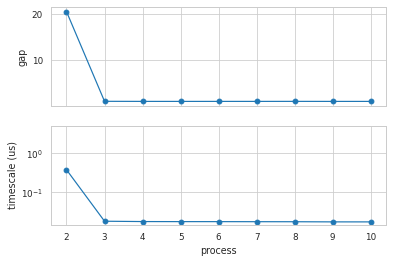

In [46]:
'''
top panel --> plot ratios of ts_n / ts_(n+1)
bottom panel --> values of timescales 
    the slowest timescale ~ 0.6 us
'''

msm = pm.msm.estimate_markov_model(dtrajs, lag=lag)
n_ts = 10
ts = msm.timescales(n_ts)
print(ts)

with sns.plotting_context('paper'):
    sns.set_style('whitegrid')
    fig, axes = plt.subplots(2, sharex=True)

    axes[0].plot(np.arange(n_ts-1)+2, ts[:-1]/ts[1:], marker='o')
    axes[0].set_ylabel('gap')
    axes[1].plot(np.arange(n_ts-1)+2, ts[:-1]/1000, marker='o')
    axes[1].set_yscale('log')
    axes[1].set_ylabel('timescale (us)')
    axes[1].set_xlabel('process')
    axes[1].set_ylim([0,5])

    plt.savefig(f'timescales_hp_ix-{hp_ix}.png', bbox_inches='tight')

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.19it/s]


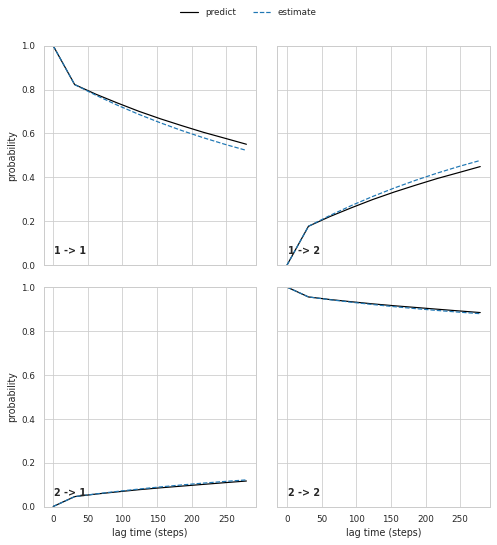

In [11]:
with sns.plotting_context('paper'):
    sns.set_style('whitegrid')
    pm.plots.plot_cktest(msm.cktest(2), figsize = (8,8))
plt.savefig(f'ck_hp_ix-{hp_ix}.png', bbox_inches='tight')    

In [ ]:
with sns.plotting_context('paper'):
    fig, ax = plt.subplots(figsize = (6,6))
    its = pm.msm.its(dtrajs, nits = 5, lags = [1, 10, 50, 100, 500, 1000], n_jobs=10)
    pm.plots.plot_implied_timescales(its, units = 'ps', dt = 1, ax = ax)
    ax.set_title("Top 5 ITS with 488 centers")
    ax.grid(visible=True, axis='y')
    fig.tight_layout()
plt.savefig(f'its_hp_ix-{hp_ix}.png', bbox_inches='tight')    

estimating MaximumLikelihoodMSM:   0%|                                                           | 0/8 [00:00<?, ?it/s]

***
## Time evolution RMSD

In [5]:
unfolded = md.load(r'../../../chignolin/protein.pdb')
native = md.load(r'../../../chignolin/5AWL_H.pdb')
trajs = md.load(traj_paths, top=top_path)
trajs.superpose(reference=unfolded)
rmsds_unfolded = md.rmsd(target=trajs, reference=unfolded)*10
trajs.superpose(reference=native)
rmsds_native = md.rmsd(target=trajs, reference=native)*10

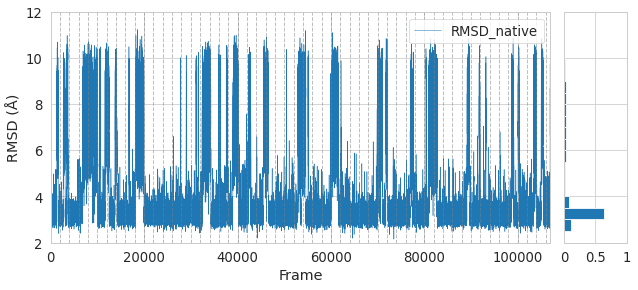

In [44]:
with sns.plotting_context('paper',font_scale=1.5):
    fig = plt.figure(figsize=(10, 4))
    gs = fig.add_gridspec(1, 2,  width_ratios=(8, 1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
    
    #ax.plot(rmsds_unfolded, lw=0.5, label='RMSD_unfolded')
    ax = fig.add_subplot(gs[0, 0])
    ax_histx = fig.add_subplot(gs[0, 1], sharey=ax)
    
    ax.plot(rmsds_native, lw=0.5, label='RMSD_native')
    
    binwidth = 0.5
    bins = np.arange(2, 13, binwidth)
    
    ax_histx.hist(rmsds_native,orientation="horizontal",bins=bins)
    ax_histx.tick_params(axis="y", labelleft=False)
    
    for i in range(0, len(rmsds_native), 2000):
        ax.axvline(i, ls='--', lw=1, c='gray', alpha=0.5)
        
    ax.set_xlim(0,106949)
    ax.set_ylim(2,12)
    
    ax_histx.set_ylim(2,12)
    ax_histx.set_xlim(0,100000)
    ax_histx.set_xticks([0,50000,100000])
    ax_histx.set_xticklabels([0,0.5,1])
    
    ax.legend()
    ax.set_xlabel('Frame')
    ax.set_ylabel('RMSD (Å)')
    plt.savefig(f'time_rmsd_hp_ix-{hp_ix}.png', bbox_inches='tight')

***
## Eigenvectors

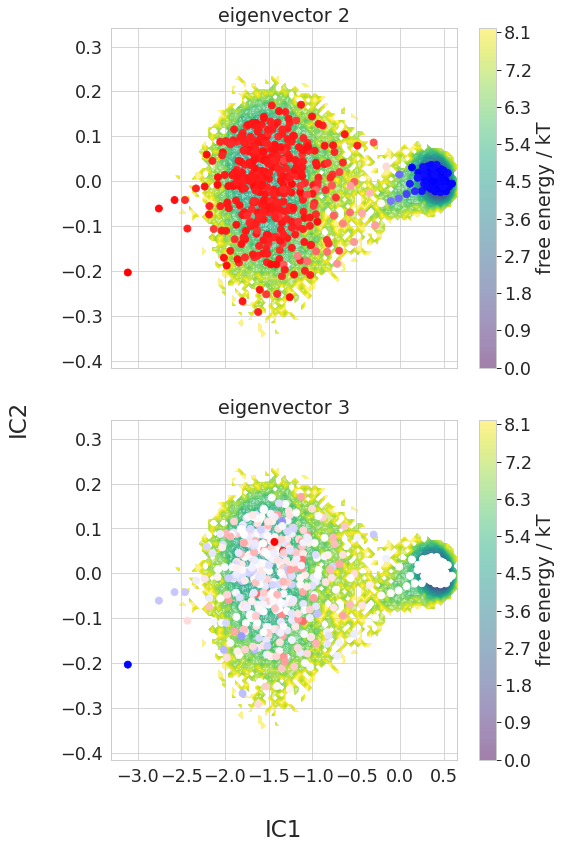

In [48]:
Y = np.concatenate(ttrajs)

with sns.plotting_context('paper', font_scale=2):
    fig, axes = plt.subplots(2, sharex=True, sharey=True, figsize=(8, 12))

    for i_ev, ax in enumerate(axes): 
        vmin = np.min(msm.eigenvectors_right()[:, i_ev+1]) 
        vmax = np.max(msm.eigenvectors_right()[:, i_ev+1]) 
        divnorm=colors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)

        if Y.shape[1]==1:
            pm.plots.plot_feature_histograms(Y, ax=ax)
            x = kmeans_mod.clustercenters[:, 0]
            y = np.repeat(0,kmeans_mod.clustercenters.shape[0])
        else:
            pm.plots.plot_free_energy(Y[:, 0], Y[:, 1], ax=ax, cmap='viridis', alpha=0.5, weights=np.concatenate(msm.trajectory_weights()))
            x = kmeans_mod.clustercenters[:, 0]
            y = kmeans_mod.clustercenters[:, 1]    
        
        ax.set_title(f'eigenvector {i_ev+2}')
        ax.scatter(x=x, y=y, c=msm.eigenvectors_right()[:, i_ev+1], cmap='bwr',norm=divnorm, s=50)
        ax.grid(visible=True, axis='both')
    fig.supxlabel('IC1')
    fig.supylabel('IC2')
    plt.tight_layout()
    plt.savefig(f'evs_hp_ix-{hp_ix}.png', bbox_inches='tight')

***
## Compare coarse-grained macrostates with crystal structures

In [49]:
Y = np.concatenate(ttrajs)
core_membership_cutoff = 0.9
n_sets = 2
_ = msm.pcca(n_sets)

In [52]:
test_traj_path = [r'../../../chignolin/5AWL_H.pdb', r'../../../chignolin/2RVD_H.pdb', r'../../../chignolin/protein.pdb']
test_labels = ['5AWL', '2RVD', 'Unfolded']
ftraj_test = featurizer(hps.loc[hp_ix, :].to_dict(), test_traj_path, top_path)
ftraj_test_tica = tica_mod.transform(ftraj_test)
microstate = kmeans_mod.assign(ftraj_test_tica)
metastate = msm.metastable_assignments[microstate]
test_dict = {label:[test_traj_path[i], microstate[i][0], metastate[i][0]] for i, label in enumerate(test_labels)}

/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


In [50]:
print('state\tπ\t\tG/kT\t\tNo.')
population = []
for i, s in enumerate(msm.metastable_sets):
    p = msm.pi[s].sum()
    population.append(p)
    print('{}\t{:f}\t{:f}\t{}'.format(i, p, -np.log(p), s.shape[0]))

state	π		G/kT		No.
0	0.004137	5.487881	14
1	0.213711	1.543130	384
2	0.782152	0.245706	90


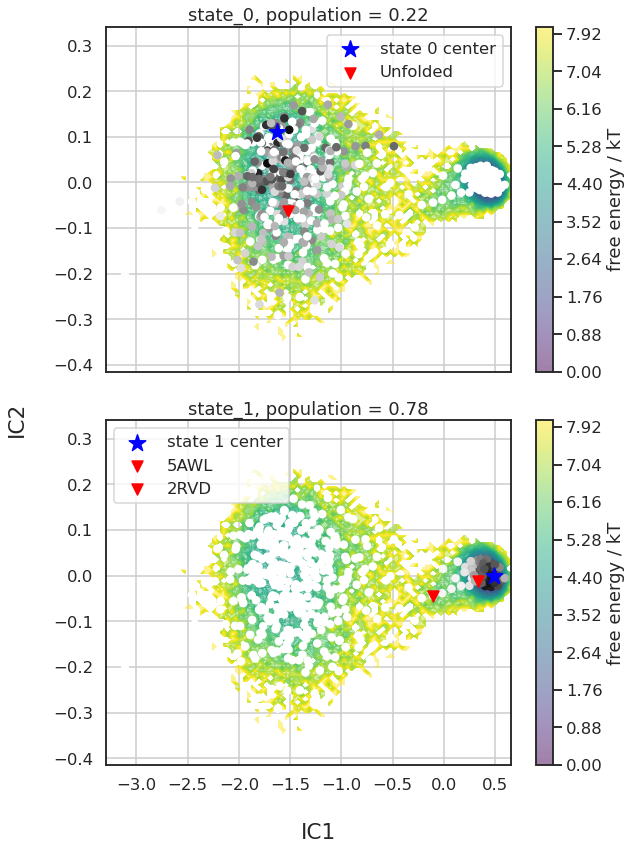

In [80]:
# Re-plot with test

with sns.plotting_context('talk'):
    fig, axes = plt.subplots(n_sets, sharex=True, sharey=True, figsize=(9, 12))

    sns.set_style('white')
    for i_set, ax in enumerate(axes): 
        if Y.shape[1]==1:
            pm.plots.plot_feature_histograms(Y, ax=ax)
            x = kmeans_mod.clustercenters[:, 0]
            y = np.repeat(0,kmeans_mod.clustercenters.shape[0])
        else:
            pm.plots.plot_free_energy(Y[:, 0], Y[:, 1], ax=ax, cmap='viridis', alpha=0.5)
            x = kmeans_mod.clustercenters[:, 0]
            y = kmeans_mod.clustercenters[:, 1]    


        ax.scatter(x=x, y=y, 
                  c=dists[i_set], cmap='Greys', s=50, vmin=dists[i_set].min(), vmax=dists[i_set].max())
        
        ax.scatter(x=x[max_ix[i_set]],y=y[max_ix[i_set]], color='b', marker='*', s=300, label=f'state {i_set} center')
        ax.grid(visible=True,axis='both')
        ax.set_title(f'state_{i_set}, population = {population[i_set]:.2f}')
    
    for i, m in enumerate(microstate):
        axes[metastate[i][0]].scatter(x=x[m],y=y[m], color='r', marker='v', s=120, label= test_labels[i])
        
    axes[0].legend()
    axes[1].legend()
    fig.supxlabel('IC1')
    fig.supylabel('IC2')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'core_membership_hp_ix-{hp_ix}_with_tests.png', bbox_inches='tight')

***
## Sample core sets of the two macrostates

In [56]:
'''
dists : probability of a metastable state to visit a microstate (2,499)
msm.metastable_memberships : probabilities of MSM states to belong to a metastable state (499,2)
------
Only preserve the microstates that has a high probablity of belonging to a metastable state
Normalize probabilities
'''

dists = msm.metastable_distributions.copy()
dists[msm.metastable_memberships.T<core_membership_cutoff] = 0
dists = dists/np.sum(dists, axis=1)[:, np.newaxis]

In [57]:
'''
np.newaxis : increase the dimensions of an existing array by 1
-----
Only keep the largest probability in metastable distribution
'''

max_dists = dists.copy()

mask = max_dists==np.tile(np.max(max_dists, axis=1)[:, np.newaxis], (max_dists.shape[1]))
max_ix = np.where(mask)[1]

max_dists[mask] = 1
max_dists[~mask] = 0

In [58]:
'''
generate 100 samples from either: the extreme microstate, or from the core set distribution
'''

is_single_core = True
if is_single_core: 
    samples = msm.sample_by_distributions(max_dists, 100)
else: 
    samples = msm.sample_by_distributions(dists, 100)
    
#ref = md.load(r'../../../chignolin/protein.pdb')
ref = md.load(r'../../../chignolin/5AWL_H.pdb')

state_out_dir = out_dir.joinpath('../').resolve().joinpath('states')
state_out_dir.mkdir(exist_ok=True, parents=True)

In [85]:
states = []

for sample_ix in range(len(samples)):

    outfile = str(state_out_dir.joinpath(f'state_{sample_ix}_is_single_core-{is_single_core}.pdb'))
    
    traj = pm.coordinates.save_traj(traj_paths, samples[sample_ix], 
                                 outfile=None, top=top_path)
    traj.superpose(reference=ref)
    states.append(traj)
    traj.save_pdb(str(outfile))
    
rmsds = [md.rmsd(target=x, reference=ref) for x in states]
rmsds_df = pd.DataFrame({f"state_{i}": rmsd*10 for i, rmsd in enumerate(rmsds)}).melt()

100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 218.38it/s]


ValueError: largest specified index (1432.0 * stride=1432.0 * 1=1432) is larger than trajectory length '../../../chignolin/CLN025-0-protein-053.xtc' = 949

In [81]:
# For CLN state 1 is the native state; state 0 is the misfolded state

with sns.plotting_context('paper', font_scale=1.5):
    sns.displot(data=rmsds_df, hue='variable', x='value', kind='kde')
    #plt.savefig(f"metastable_states_rmsd_{hp_ix}.png")
    plt.xlabel(f'RMSD (Å) rel. to 5AWL')
    plt.grid(visible=True, axis='both')
    plt.xticks(np.linspace(0,12,7))
    plt.yticks(np.linspace(0,1,6))
    plt.savefig(f'rmsd_to_xtal_{hp_ix}_single_core-{is_single_core}.png', bbox_inches='tight')

NameError: name 'rmsds_df' is not defined

***
## Compute characteristics of macrostates and identify structural diffrerences

In [66]:
colors = ['#165ac7','#bf6204','#4ad41c']
test={}
test['5AWL'] = test_dict['5AWL']
test['2RVD'] = test_dict['2RVD']
test['Unfolded'] = test_dict['Unfolded']

In [67]:
is_single_core = False
state_0_core = str(state_out_dir.joinpath(f'state_0_is_single_core-{is_single_core}.pdb'))
state_1_core = str(state_out_dir.joinpath(f'state_1_is_single_core-{is_single_core}.pdb'))

samples = [state_0_core, state_1_core]
titles = ['state_0_core', 'state_1_core']

# native H-bond: Asp3O(56) - Gly7N(101); Asp3N(45) - Thr8O(120); Asp3_sidechainO(53/54) - Glu5N(71)
native_Hbond_pairs = np.array([[56,101],[45,120],[53,71],[54,71]])
native_legend = ['Asp3O - Gly7N', 'Asp3N - Thr8O', 'Asp3OD - Glu5N']
# misfolded H-bond: Asp3N(45) - Gly7O(106); Tyr2N(24) - Thr8O(120); Asp3O(56) - Thr8(107)
misfold_Hbond_pairs = np.array([[45,106],[24,120],[56,107]])
misfold_legend = ['Asp3N - Gly7O', 'Tyr2N - Thr8O', 'Asp3O - Thr8N']

/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/MDAnalysis/analysis/base.py:438: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[i] = ts.time
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/MDAnalysis/analysis/dihedrals.py:322: DeprecationWarning: The `angle` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.angles` instead
  warnings.warn(wmsg, DeprecationWarning)
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:345: UserWarning: Unknown element  found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/home/rzhu/miniconda3/envs/msm_opt/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 
  warnings.warn("Failed to guess the mass for the following ato

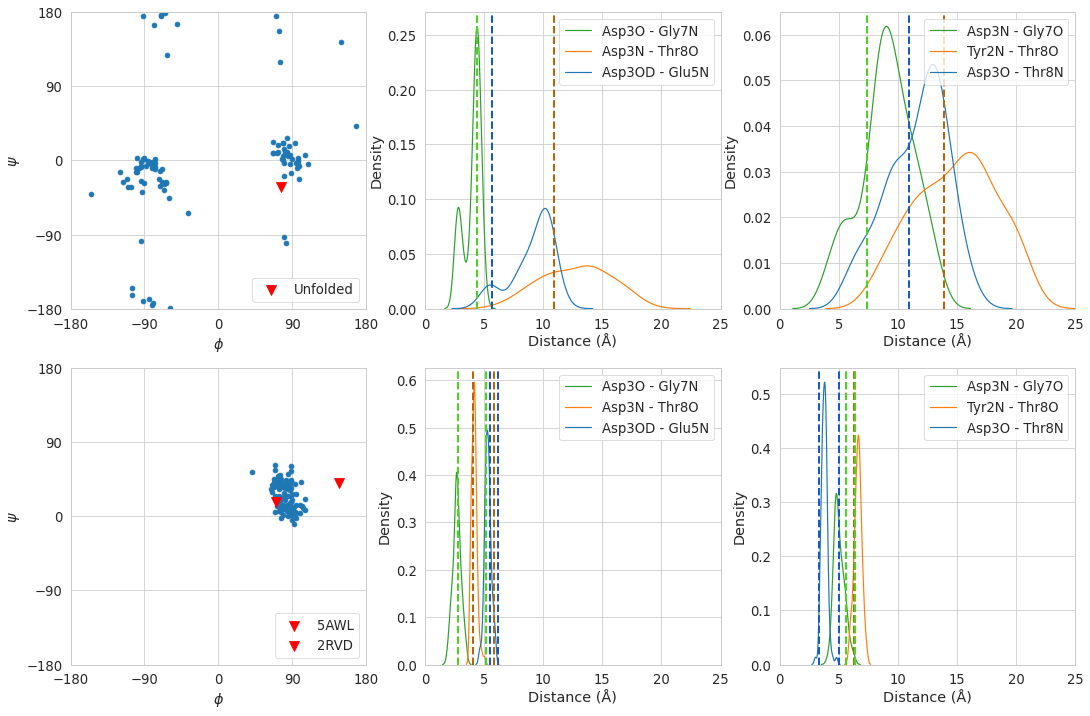

In [69]:
with sns.plotting_context('paper', font_scale=1.5):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    for i, sample in enumerate(samples):
        sample_mda = mda.Universe(sample)
        ags_phi, ags_psi = sample_mda.residues[6].phi_selection(), sample_mda.residues[6].psi_selection()
        phi = Dihedral([ags_phi]).run().angles
        psi = Dihedral([ags_psi]).run().angles
        
        axes[i,0].scatter(phi, psi)
        
        sample_md = md.load(sample)
        
        native_Hbond_distances = md.compute_distances(sample_md, native_Hbond_pairs)*10
        sns.kdeplot(np.concatenate([native_Hbond_distances[:,:2], np.amin((native_Hbond_distances[:,2], native_Hbond_distances[:,3]), axis=0)[:,None]], axis=1),
                    ax=axes[i,1], legend=False)
        
        misfold_Hbond_distances = md.compute_distances(sample_md, misfold_Hbond_pairs)*10
        sns.kdeplot(misfold_Hbond_distances, ax=axes[i,2], legend=False)
    
    for k, v in test.items():
        test_mda = mda.Universe(v[0])
        ags_phi, ags_psi = test_mda.residues[6].phi_selection(), test_mda.residues[6].psi_selection()
        phi = Dihedral([ags_phi]).run().angles
        psi = Dihedral([ags_psi]).run().angles
        axes[v[2]-1,0].scatter(phi, psi, color='r', marker='v', s=100, label=k)

        test_md = md.load(v[0])
        native_Hbond_distances = md.compute_distances(test_md, native_Hbond_pairs)*10
        native_Hbond_distances_min = np.concatenate([native_Hbond_distances[:,:2], np.amin((native_Hbond_distances[:,2], native_Hbond_distances[:,3]), axis=0)[:,None]], axis=1)[0]
        misfold_Hbond_distances = md.compute_distances(test_md, misfold_Hbond_pairs)[0]*10
        
        for j in range(len(native_Hbond_distances_min)):
            axes[v[2]-1,1].axvline(native_Hbond_distances_min[j], ls='--', lw=2, c=colors[j])
            axes[v[2]-1,2].axvline(misfold_Hbond_distances[j], ls='--', lw=2, c=colors[j])
        
    for i in range(len(samples)):
        axes[i,0].set_xlim([-180,180])
        axes[i,0].set_ylim([-180,180])
        axes[i,0].set_xticks([-180, -90 ,0, 90, 180])
        axes[i,0].set_yticks([-180, -90 ,0, 90, 180])
        axes[i,0].set_xlabel('$\phi$')
        axes[i,0].set_ylabel('$\psi$')
        axes[i,0].legend(loc='lower right')
        
        axes[i,1].legend(native_legend)
        axes[i,1].set_xlim([0,25])
        axes[i,1].set_xlabel('Distance (Å)')

        axes[i,2].legend(misfold_legend)
        axes[i,2].set_xlim([0,25])
        axes[i,2].set_xlabel('Distance (Å)')
        
    plt.savefig(f'macrostates_comparison-{is_single_core}.png', bbox_inches='tight')

***
### Extract training and test sets for molearn

Goal : Find folding coordinates between state 0 (denatured) and 1 (native)

Training set : 90% of the core sets of both state 0 and 1

Test set core: the rest 10% of the core sets

Test set intermediates : other frames

In [155]:
traj_path = r'../../../chignolin/cat_traj.xtc'
np.random.seed(seed)

core_membership_cutoff = 0.90
dists = msm.metastable_distributions.copy()
dists[msm.metastable_memberships.T<core_membership_cutoff] = False
dists[msm.metastable_memberships.T>=core_membership_cutoff] = True

dtrajs = np.concatenate(kmeans_mod.dtrajs)
core_frames = np.logical_or(dists[0][dtrajs], dists[1][dtrajs])
core_index = np.array(range(len(dtrajs)))[core_frames]

np.random.shuffle(core_index)
training_index = core_index[len(core_index)//10:]
test_core_index = core_index[:len(core_index)//10]
test_inter_index = np.array(range(len(dtrajs)))[~core_frames]

print(f'training set length: {training_index.shape[0]}')
print(f'test set core length: {test_core_index.shape[0]}')
print(f'test set intermediate length: {test_inter_index.shape[0]}')

protein = md.load(traj_path, top = top_path)
protein = protein.superpose(reference = ref)

training set length: 88062
test set core length: 9784
test set intermediate length: 9103


In [156]:
protein.slice(training_index).save_pdb(r'/home/rzhu/Desktop/molearn/chignolin/training_set.pdb')
protein.slice(test_inter_index).save_pdb(r'/home/rzhu/Desktop/molearn/chignolin/test_inter.pdb')
protein.slice(test_core_index).save_pdb(r'/home/rzhu/Desktop/molearn/chignolin/test_core.pdb')